### Add images to CSV BBOX

In [5]:
import os
import pandas as pd
import glob

def find_image_name(row, image_dict):
    """
    Construct the image name based on row's id and frame_number,
    then check if it exists in the image_dict.
    """
    id_frame_pattern = f"img_{int(row['id'])}_{int(row['frame_number'])}"
    matched_images = [img for img in image_dict.get(int(row['id']), []) if id_frame_pattern in img]
    return matched_images[0] if matched_images else None

def append_image_names(csv_path, base_path):
    # Load the CSV into a DataFrame
    df = pd.read_csv(csv_path, dtype={'id': 'int64','frame_number': 'int64'})

    # Dictionary to hold image names for each id
    image_dict = {}

    # List directories in the base path and filter by those matching the ids in the DataFrame
    for dir_name in os.listdir(base_path):
        dir_path = os.path.join(base_path, dir_name)
        if os.path.isdir(dir_path) and dir_name.isdigit():
            id = int(dir_name)
            # List all images for the current id
            image_dict[id] = [os.path.basename(x) for x in glob.glob(os.path.join(dir_path, "*.png"))]

    # Apply the function to find the matching image name for each row
    df['img_name'] = df.apply(lambda row: find_image_name(row, image_dict), axis=1)
    
    return df


BASE_IMAGEES_PATH = '/home/diego/Documents/yolov7-tracker/imgs_conce'
BASE_FOLDER_NAME = 'logs'
CSV_FILE_PATH = 'conce_bbox.csv'

CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, CSV_FILE_PATH)
updated_df = append_image_names(CSV_FILE_PATH, BASE_IMAGEES_PATH)

updated_df.to_csv(CSV_FILE_PATH, index=False)

### Add kfold to images and add label_img, label_direction column

In [6]:
# Re-importing necessary libraries and redefining the function with corrections
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import os
# Re-defining the set_folds function
def set_folds(csv_path, k_folds, n_images):
    df = pd.read_csv(csv_path)

    # Ensure 'img_name' column exists
    if 'img_name' not in df.columns:
        raise ValueError("img_name column doesn't exist in the dataset.")

    # Initialize k_fold column in original df
    df['k_fold'] = np.nan
    df['label_img'] = np.nan
    df['label_direction'] = np.nan

    # Filter rows where 'img_name' is not empty
    df_filtered = df[df['img_name'] != ''].copy()

    # Sort by 'id' and 'frame_number'
    df_filtered.sort_values(by=['id', 'frame_number'], inplace=True)

    # Process each ID separately in filtered df
    for id_value in df_filtered['id'].unique():
        subset = df_filtered[(df_filtered['id'] == id_value) & (df_filtered['img_name'].notna())]

        # Apply KFold or assign all to the same fold if condition is met
        if len(subset) < k_folds * n_images:
            df.loc[subset.index, 'k_fold'] = 0  # Assign all to fold 0 if condition is met
        else:
            # Apply KFold
            kf = KFold(n_splits=k_folds)
            for fold, (_, test_index) in enumerate(kf.split(subset)):
                # Select n_images per fold if specified
                #selected_indices = test_index[:n_images] if n_images < len(test_index) else test_index Selecciona los primeros n_images
                selected_indices = np.random.choice(test_index, min(n_images, len(test_index)), replace=False)
                df.loc[subset.iloc[selected_indices].index, 'k_fold'] = fold
                df.loc[subset.iloc[selected_indices].index, 'label_img'] = 0
    return df

BASE_FOLDER_NAME = 'logs'
CSV_FILE_PATH = 'conce_bbox.csv'
CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, CSV_FILE_PATH)
df_with_folds = set_folds(CSV_FILE_PATH, k_folds=5, n_images=3)

df_with_folds.to_csv(CSV_FILE_PATH, index=False)


### CSV to SQL LITE

In [2]:
import pandas as pd
import sqlite3
import os

def convert_csv_to_sqlite(csv_file_path, db_file_path, table_name='bbox_data'):
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file_path)
    
    # Create a connection to the SQLite database
    conn = sqlite3.connect(db_file_path)
    
    # Write the data to a SQLite table
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    
    # Close the connection
    conn.close()

BASE_FOLDER_NAME = 'logs'
CSV_FILE_PATH = 'conce_bbox.csv'

CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, CSV_FILE_PATH)

db_file_path = f'{BASE_FOLDER_NAME}/bbox_data.db'
convert_csv_to_sqlite(CSV_FILE_PATH, db_file_path)

### SQLite -> CSV

In [36]:
import pandas as pd
import sqlite3
import os

def convert_sqlite_to_csv(db_file_path, csv_file_path, table_name='bbox_data'):
    # Create a connection to the SQLite database
    conn = sqlite3.connect(db_file_path)
    
    # Read the table into a pandas DataFrame
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    
    # Write the DataFrame to a CSV file
    df.to_csv(csv_file_path, index=False)
    
    # Close the connection
    conn.close()

BASE_FOLDER_NAME = 'logs'

db_file_path = f'{BASE_FOLDER_NAME}/bbox_data.db'
CSV_FILE_PATH = 'converted_bbox.csv'
CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, CSV_FILE_PATH)

convert_sqlite_to_csv(db_file_path, CSV_FILE_PATH)

### Model Image Selection

In [27]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


BASE_FOLDER_NAME = 'logs'
CSV_FILE_NAME = 'converted_bbox.csv'
CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, CSV_FILE_NAME)


MODEL_RESULT = os.path.join(BASE_FOLDER_NAME, f'model_img_selction{CSV_FILE_NAME}')



INTEREST_LABEL = 'label_img'
interest_values = [1, 2]  # Define the values you're interested in BAD and GOOD images


# Load your data
df = pd.read_csv(CSV_FILE_PATH)

# Preprocess your data
df[INTEREST_LABEL] = df[INTEREST_LABEL].apply(lambda x: x if x in interest_values else None).astype(float)


# Further filter the DataFrame to only include rows with ID lower than 1300 for training
train_df = df[(df['id'] < 1300) & df[INTEREST_LABEL].notna()]

# For prediction, you'd consider rows beyond ID 1300 or those not fitting the interest labels
predict_df = df[(df['id'] >= 1300) | df[INTEREST_LABEL].isna()] ##### OJO ESTO

#Filter only the rows that has img_name
predict_df = predict_df.dropna(subset=['img_name'])

# Define features and target
features = ['area', 'centroid_x', 'centroid_y', 'frame_number', 'overlap', 'distance_to_center', 'conf_score']
target = INTEREST_LABEL

# Splitting the training data for validation
X_train, X_val, y_train, y_val = train_test_split(train_df[features], train_df[target], test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Validate the model
val_predictions = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy}")

# Predicting on the dataset without labels
predict_features = predict_df[features]
predicted_labels = model.predict(predict_features)
predicted_confidences = model.predict_proba(predict_features).max(axis=1)

# Adding predictions back to the dataframe
predict_df['model_label_img'] = predicted_labels
predict_df['model_label_conf'] = predicted_confidences

# Combine the prediction and training dataframes
final_df = pd.concat([train_df, predict_df], sort=False)

# Save the updated dataframe to a new CSV file
final_df.to_csv(MODEL_RESULT, index=False) #-> SAVE

print("Updated CSV saved successfully.")
### OJO DIEGO ###
# Este resultado se le quitan todas las rows que no tienen img_name

/tmp/ipykernel_8110/4239801089.py:25: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_FILE_PATH)


Validation Accuracy: 0.900990099009901
Updated CSV saved successfully.


### Model Image Selection Test

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
FOLDER_PATH_IMGS = '/home/diego/Documents/yolov7-tracker/imgs_conce/'


# Filter final_df to include only rows where both 'model_label_img' and INTEREST_LABEL are not null
comparison_df = final_df.dropna(subset=['model_label_img', INTEREST_LABEL])
# Extract model predictions and actual labels
y_pred = comparison_df['model_label_img']
y_true = comparison_df[INTEREST_LABEL]

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
cmd = ConfusionMatrixDisplay(cm, display_labels=interest_values)
cmd.plot(cmap="Blues")
cmd.ax_.set(xlabel='Predicted labels', ylabel='True labels', title='Confusion Matrix')
plt.show()

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=[str(label) for label in interest_values])

print("Classification Report:")
print(report)

# Assuming 'comparison_df' contains the actual (INTEREST_LABEL) and predicted ('model_label_img') labels
# Let's identify False Negatives: actual label is in interest_values, but predicted is not.
total_wrong_filter = (comparison_df[INTEREST_LABEL].isin(interest_values)) & (comparison_df['model_label_img'] != comparison_df[INTEREST_LABEL])
false_negative_filter = (comparison_df[INTEREST_LABEL] == 1) & (comparison_df['model_label_img'] == 2) # False Negative filter
false_positive_filter = (comparison_df[INTEREST_LABEL] == 2) & (comparison_df['model_label_img'] == 1) # False Positive filter

false_negatives = comparison_df[false_negative_filter]

# Assuming 'img_name' column exists and contains the path to images
fn_images = false_negatives['img_name'].tolist()[:20]

# Define the grid size for plotting
n_rows = 2  # Adjust based on the number of images you want per column
n_cols = (len(fn_images) + 1) // n_rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
fig.suptitle('False Negative Images')

# Flatten the axes array for easy indexing
axes = axes.flatten()

for i, img_name in enumerate(fn_images):
    img_path = os.path.join(FOLDER_PATH_IMGS,img_name.split('_')[1], img_name)
    img = mpimg.imread(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f'FN Image {i+1} img_name: {img_name.split("_")[1]}_{img_name.split("_")[2]}')
    axes[i].axis('off')

# Hide any empty subplots
for j in range(i + 1, n_rows * n_cols):
    axes[j].axis('off')

plt.tight_layout()
# Save the figure to disk
save_path = 'logs/imageSelectionResults.png'  # Specify your desired path and filename
plt.savefig(save_path, dpi=300)  # Adjust DPI for higher resolution images
plt.show()

### Data process IN/OUT/BAD Feature Engineering

In [162]:
import pandas as pd
import os
import numpy as np

BASE_FOLDER_NAME = 'logs'
CSV_FILE_PATH = 'converted_bbox.csv'
CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, CSV_FILE_PATH)

# Load your data
df = pd.read_csv(CSV_FILE_PATH)


## TEMPORAL ###
label_index = df.columns.get_loc('label_direction')
df = df.iloc[:, :label_index + 1]
## TEMPORAL ###

# Ensure the DataFrame is sorted by 'id' and 'frame_number' for correct diff calculations
df.sort_values(by=['id', 'frame_number'], inplace=True)

# Calculate Movement Features (Δx and Δy)
df['delta_x'] = df.groupby('id')['centroid_x'].diff().fillna(0)
df['delta_y'] = df.groupby('id')['centroid_y'].diff().fillna(0)

##### NEW #####



##### NEW #####

# Calculate Aggregated Features for each ID
aggregations = {
    'delta_x': ['mean', 'max', 'min', 'std'],
    'delta_y': ['mean', 'max', 'min', 'std']
}
aggregated_features = df.groupby('id').agg(aggregations).reset_index()

# Correct the naming of the aggregated columns
aggregated_features.columns = ['id'] + [f'{var}_{stat}' for var, stats in aggregations.items() for stat in stats]

# Correctly merge aggregated features back to the original dataframe
df = pd.merge(df, aggregated_features, on='id', how='left')

# Calculate Sequence Features (net movement direction)
df['net_movement_x'] = df.groupby('id')['delta_x'].transform('sum')
df['net_movement_y'] = df.groupby('id')['delta_y'].transform('sum')

df.to_csv(CSV_FILE_PATH, index=False)

print("Updated CSV saved successfully.")

Updated CSV saved successfully.


### Model In vs Out

/tmp/ipykernel_6418/4108579064.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['label_direction_encoded'] = label_encoder.fit_transform(train_df[INTEREST_LABEL])  # 'IN' -> 1, 'OUT' -> 0


Validation Accuracy: 1.0
LabelEncoder classes: ['IN' 'OUT']
LabelEncoder inverse transform: ['OUT' 'IN']
Updated CSV saved successfully.


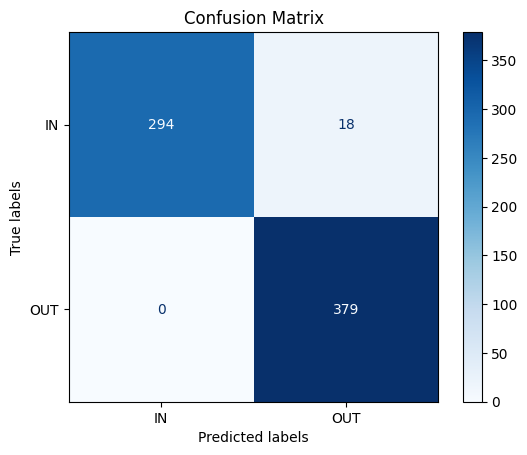

/tmp/ipykernel_6418/3484062763.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  middle_images = false_positives_df.groupby('id').apply(lambda x: x.iloc[(len(x) - 1) // 2])


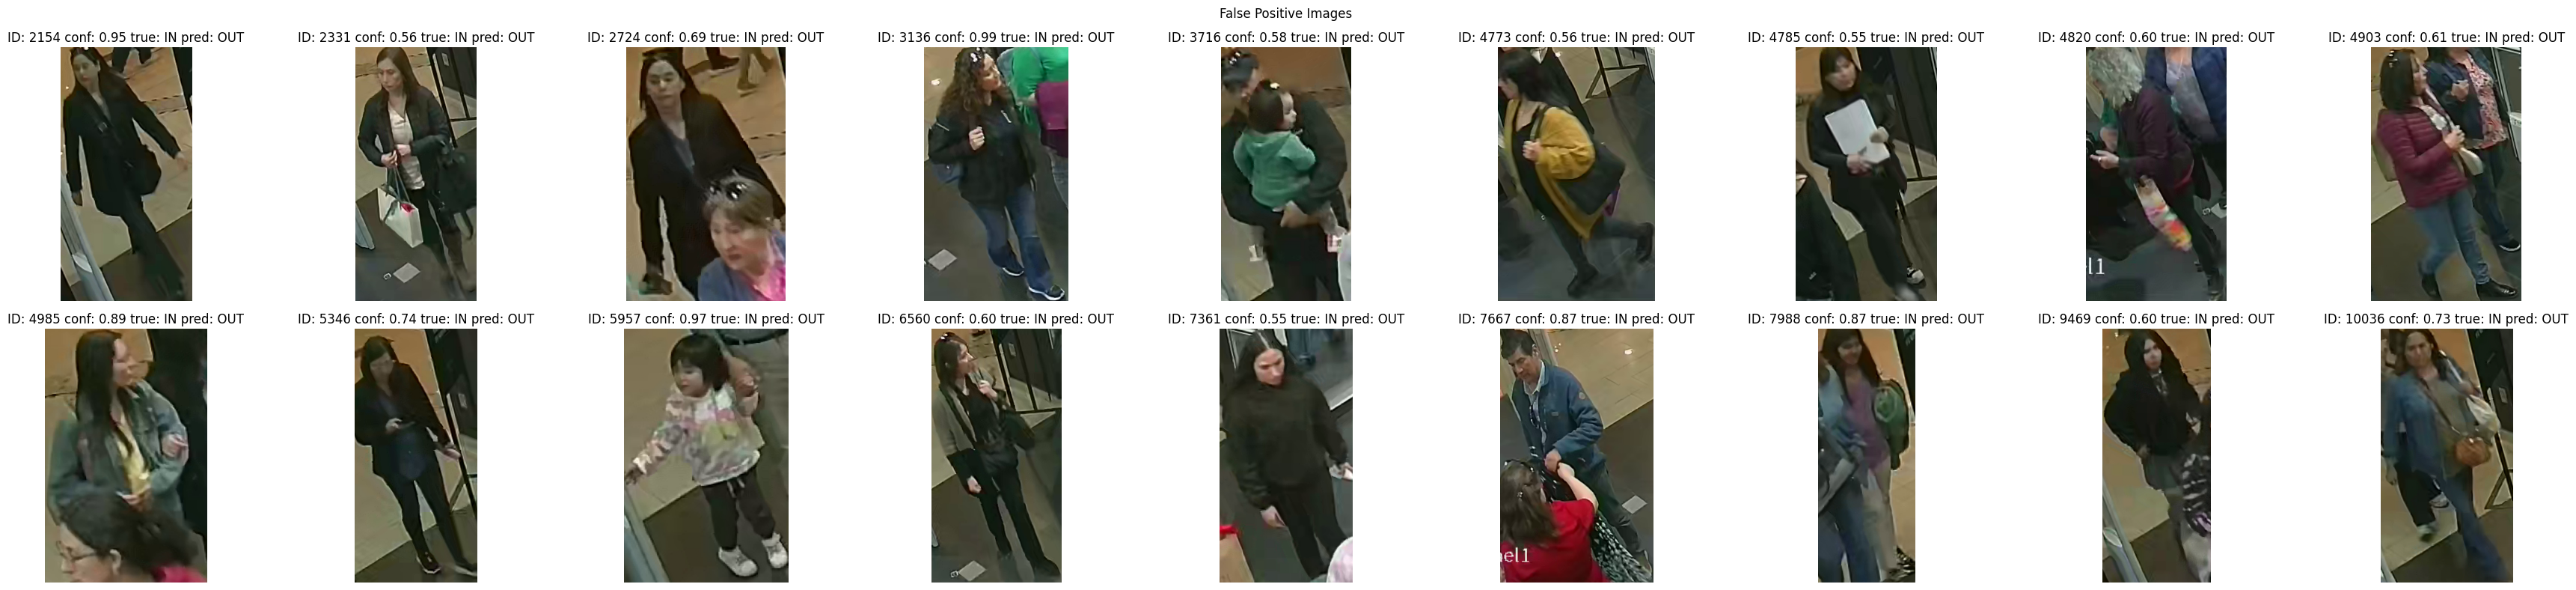

/tmp/ipykernel_6418/2441558277.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  middle_true_positives = true_positives.groupby(id_column).apply(lambda x: x.iloc[(len(x) - 1) // 2])


conf_interval
0.50-0.55      0
0.55-0.60      1
0.60-0.65      0
0.65-0.70      0
0.70-0.75      0
0.75-0.80     12
0.80-0.85      0
0.85-0.90      0
0.90-0.95     14
0.95-1.00    650
Name: count, dtype: int64

In [184]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report,confusion_matrix

BASE_FOLDER_NAME = 'logs'
CSV_FILE_NAME = 'converted_bbox.csv'
CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, CSV_FILE_NAME)
INTEREST_LABEL = 'label_direction'
NEW_FILE = 'updated_conce_bbox_with_predictions.csv'

MODEL_RESULT = os.path.join(BASE_FOLDER_NAME, f'model_inout_{CSV_FILE_NAME}')

df = pd.read_csv(CSV_FILE_PATH)

# df_filtered = df[(df[INTEREST_LABEL] == 'IN') | (df[INTEREST_LABEL] == 'OUT')] # FUNCIONA

# Aca puede pasar que tengo solo hasta el ID 600 con etiquetas, 
# por ende necesito menor que el ID 1300 y que tengan las etiqeutas IN or OUT, y no BAD ni blanks
train_df = df[(df['id'] < 1300) & (df[INTEREST_LABEL] == 'IN') | (df[INTEREST_LABEL] == 'OUT')]

# Pero para el predict, necesito todas las arriba de 1300 y sacar los BADs solo si es que hay anotadas
# si no da igual, ahora si hay IN or OUT, me va a servir para despues, pero pueden haber unos pocos o muchos
# solo me va a servir para la confusion matrix
predict_df = df[(df['id'] >= 1300) & (df[INTEREST_LABEL] != 'BAD')]


# Correctly encode 'IN' as 1 and 'OUT' as 0
label_encoder = LabelEncoder()
train_df['label_direction_encoded'] = label_encoder.fit_transform(train_df[INTEREST_LABEL])  # 'IN' -> 1, 'OUT' -> 0

not_imporant_features = ['id',
                         INTEREST_LABEL,
                         'label_direction_encoded',
                         'conf_score',
                         'k_fold',
                         'label_img',
                         'overlap',
                         'area',
                         'frame_number',
                         ]
# Define features (make sure to only include numeric columns and exclude any text columns)
features = [col for col in train_df.columns if col not in not_imporant_features and train_df[col].dtype in [np.int64, np.float64]]
target = 'label_direction_encoded'

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(train_df[features], train_df[target], test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
val_predictions = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy}")




predict_df = predict_df.dropna(subset=features)
# Predicting on the dataset without labels
predict_features = predict_df[features]
predicted_labels = model.predict(predict_features)
predicted_confidences = model.predict_proba(predict_features).max(axis=1)

# Adding predictions back to the dataframe
predict_df['model_label_direction'] = predicted_labels
predict_df['model_label_direction_conf'] = predicted_confidences
predict_df['model_label_direction'] = label_encoder.inverse_transform(predict_df['model_label_direction'].astype(int))

# Combine the prediction and training dataframes
final_df = pd.concat([train_df, predict_df], sort=False)

# Save the updated dataframe to a new CSV file
final_df.to_csv(MODEL_RESULT, index=False) 

label_encoder.classes_
label_encoder.inverse_transform([1,0])
print("LabelEncoder classes:", label_encoder.classes_)
print("LabelEncoder inverse transform:", label_encoder.inverse_transform([1, 0]))
print("Updated CSV saved successfully.")


################################################ TESTING ################################################
agg_df = aggregate_and_compare_predictions(final_df, 'model_label_direction', 'label_direction')
plot_confusion_matrix(agg_df)
plot_false_positives(agg_df, final_df, img_name_col='img_name',true_label_col='label_direction', pred_label_col='model_label_direction', conf_col='model_label_direction_conf', base_img_path=FOLDER_PATH_IMGS, save_path='logs/false_positive_images.png', nrows=2)
calculate_confidence_distribution(comparison_df, 'id', 'label_direction', 'model_label_direction', 'model_label_direction_conf')


### Model In vs Out Confusion Matrix, Plot, y Conf

In [182]:
import pandas as pd
import numpy as np
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

def aggregate_and_compare_predictions(df, pred_column, true_column,agg_df_true='y_true',agg_df_pred='y_pred', id_column='id'):
    """
    Aggregates predictions and true labels by ID.

    Parameters:
    - df: DataFrame containing the predictions, true labels, and IDs.
    - pred_column: The name of the column containing model predictions.
    - true_column: The name of the column containing true labels.
    - id_column: The name of the column containing unique identifiers for aggregation.

    Returns:
    - agg_df: DataFrame with aggregated true labels and predictions.
    """
    # Drop rows where either prediction or true label is NaN
    comparison_df = df.dropna(subset=[pred_column, true_column])
    
    # Aggregate predictions and true labels
    agg_pred = comparison_df.groupby(id_column)[pred_column].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    agg_true = comparison_df.groupby(id_column)[true_column].agg(lambda x: x.iloc[0])
    
    # Create a DataFrame from the aggregated data
    agg_df = pd.DataFrame({agg_df_true: agg_true, agg_df_pred: agg_pred}).dropna()
    

    # Para pasar de IN OUT a numeros
    # Encode labels if they are categorical
    # if agg_df[agg_df_true].dtype == object or agg_df[agg_df_pred].dtype == object:
    #     le = LabelEncoder()
    #     agg_df[agg_df_true] = le.fit_transform(agg_df[agg_df_true])
    #     agg_df[agg_df_pred] = le.transform(agg_df[agg_df_pred])
    
    return agg_df

def plot_confusion_matrix(agg_df, true_label_col='y_true', pred_label_col='y_pred'):
    """
    Plots a confusion matrix based on aggregated true labels and predictions.

    Parameters:
    - agg_df: DataFrame with aggregated true labels and predictions.
    - true_label_col: Column name for the true label in agg_df.
    - pred_label_col: Column name for the predicted label in agg_df.
    """
    # Generate the confusion matrix
    cm = confusion_matrix(agg_df[true_label_col], agg_df[pred_label_col], labels=np.unique(agg_df[true_label_col]))
    
    # Display the confusion matrix
    cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(agg_df[true_label_col]))
    cmd.plot(cmap="Blues")
    cmd.ax_.set(xlabel='Predicted labels', ylabel='True labels', title='Confusion Matrix')
    plt.show()

# De los verdadros que nivel de confianza existe
def calculate_confidence_distribution(comparison_df, id_column, label_direction_column, model_label_direction_column, model_label_direction_conf_column):
    """
    Calculates and displays the distribution of confidence scores for true positive predictions.

    Parameters:
    - comparison_df: DataFrame containing the comparison data.
    - id_column: The name of the column containing unique identifiers.
    - label_direction_column: The name of the column containing true labels.
    - model_label_direction_column: The name of the column containing model predictions.
    - model_label_direction_conf_column: The name of the column containing model prediction confidences.

    Returns:
    - A distribution of confidence scores for true positive predictions.
    """
    # Filtering out rows with NaN true labels
    comparison_df = comparison_df.dropna(subset=[model_label_direction_column, label_direction_column])
    
    # Aggregate true positive predictions
    true_positives = comparison_df[
        (comparison_df[model_label_direction_column] == comparison_df[label_direction_column])
    ]
    
    # Middle prediction per ID for true positives
    middle_true_positives = true_positives.groupby(id_column).apply(lambda x: x.iloc[(len(x) - 1) // 2])
    
    # Define bins for the confidence scores
    bins = np.arange(0.5, 1.05, 0.05)
    labels = [f"{i:.2f}-{i+0.05:.2f}" for i in bins[:-1]]  # Labels for the intervals
    
    # Bin the data
    middle_true_positives['conf_interval'] = pd.cut(
        middle_true_positives[model_label_direction_conf_column],
        bins=bins,
        labels=labels,
        right=False
    )
    
    # Count the occurrences in each bin
    distribution = middle_true_positives['conf_interval'].value_counts().sort_index()
    
    # Display the distribution
    return distribution

def plot_false_positives(agg_df, comparison_df,agg_df_true='y_true',agg_df_pred='y_pred', img_name_col='img_name', true_label_col='y_true', pred_label_col='y_pred', conf_col='model_label_direction_conf', base_img_path=FOLDER_PATH_IMGS, save_path='logs/false_positive_images.png', nrows=2):
    """
    Plots false positive images based on aggregated data.

    Parameters:
    - agg_df: DataFrame with aggregated data containing true and predicted labels.
    - comparison_df: Original comparison DataFrame with detailed data.
    - img_name_col: Column name containing the image filenames.
    - true_label_col: Column name for the true label.
    - pred_label_col: Column name for the predicted label.
    - conf_col: Column name for the model confidence.
    - base_img_path: Base path to the image directory.
    - save_path: Path to save the plotted figure.
    - nrows: Number of rows in the plot grid.
    """
    # Identify false positives at the ID level based on the aggregated data
    false_positive_ids = agg_df[(agg_df[agg_df_true] == 'IN') & (agg_df[agg_df_pred] == 'OUT')].index

    # Filter the original comparison_df to get rows that match false positive IDs
    false_positives_df = comparison_df[comparison_df['id'].isin(false_positive_ids)]
    false_positives_df = false_positives_df.dropna(subset=[img_name_col])

    # Group by ID and select the middle image for each group
    middle_images = false_positives_df.groupby('id').apply(lambda x: x.iloc[(len(x) - 1) // 2])
    false_positives_df = middle_images.reset_index(drop=True)

    # Define the grid size for plotting
    ncols = (len(false_positives_df) + nrows - 1) // nrows  # Adjust the calculation as needed
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
    fig.suptitle('False Positive Images')

    # Flatten the axes array for easy indexing
    axes = axes.flatten()

    for i, row in false_positives_df.iterrows():
        img_name = row[img_name_col]
        img_path = os.path.join(base_img_path, img_name.split('_')[1], img_name)  # Adjust path construction as needed
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'ID: {row["id"]} conf: {row[conf_col]:.2f} true: {row[true_label_col]} pred: {row[pred_label_col]}')
        axes[i].axis('off')

    # Hide any empty subplots
    for j in range(i + 1, nrows * ncols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)  # Adjust DPI for higher resolution images
    plt.show()



### In|OUT vs BAD

In [20]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

BASE_FOLDER_NAME = 'logs'
CSV_FILE_PATH = 'conce_bbox.csv_alternative.csv'
CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, CSV_FILE_PATH)

# Load the original data
df_original = pd.read_csv(CSV_FILE_PATH)

# Create a copy for processing
df = df_original.copy()

# Encode labels: 1 for 'IN' or 'OUT' (good image), 0 for 'BAD' (bad image), keep NaN for now
df['label_encoded'] = df['label_direction'].apply(lambda x: 1 if x in ['IN', 'OUT'] else 0 if x == 'BAD' else np.nan)

# Prepare data for model training (exclude rows with NaN in 'label_encoded')
df_train = df.dropna(subset=['label_encoded'])

# Define features (excluding non-numeric columns and the 'label_direction', 'label_encoded' columns)
features = [col for col in df_train.columns if col not in ['id', 'label_direction', 'label_encoded'] and df_train[col].dtype in [np.int64, np.float64]]
target = 'label_encoded'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train[target], test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the entire original dataset (make sure to handle NaNs in features if they exist)
df_original['label_good_dir'] = model.predict(df_original[features].fillna(0))  # Using fillna(0) as an example handling method
df_original['label_good_dir_conf'] = model.predict_proba(df_original[features].fillna(0))[:, 1]  # Confidence of being a good image

# Save the updated dataframe with predictions for the entire dataset to a new CSV file
NEW_CSV_PATH = os.path.join(BASE_FOLDER_NAME, 'updated_conce_bbox_with_good_dir_predictions.csv')
df_original.to_csv(NEW_CSV_PATH, index=False)

print("Updated CSV with good direction predictions saved successfully.")


/tmp/ipykernel_12258/3214391915.py:13: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv(CSV_FILE_PATH)


Updated CSV with good direction predictions saved successfully.
